Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Objective: To create a multiclass classification model based on convolutional neural network using tensorflow

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [5]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [6]:
ls "/content/gdrive/My Drive/CNN/Skin_Data_Store/Skin_cancer_DS /"

Test/  Train/


In [7]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = '/content/gdrive/MyDrive/CNN/Skin_Data_Store/Skin_cancer_DS '
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [8]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


This assignment uses a dataset of about 2239 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

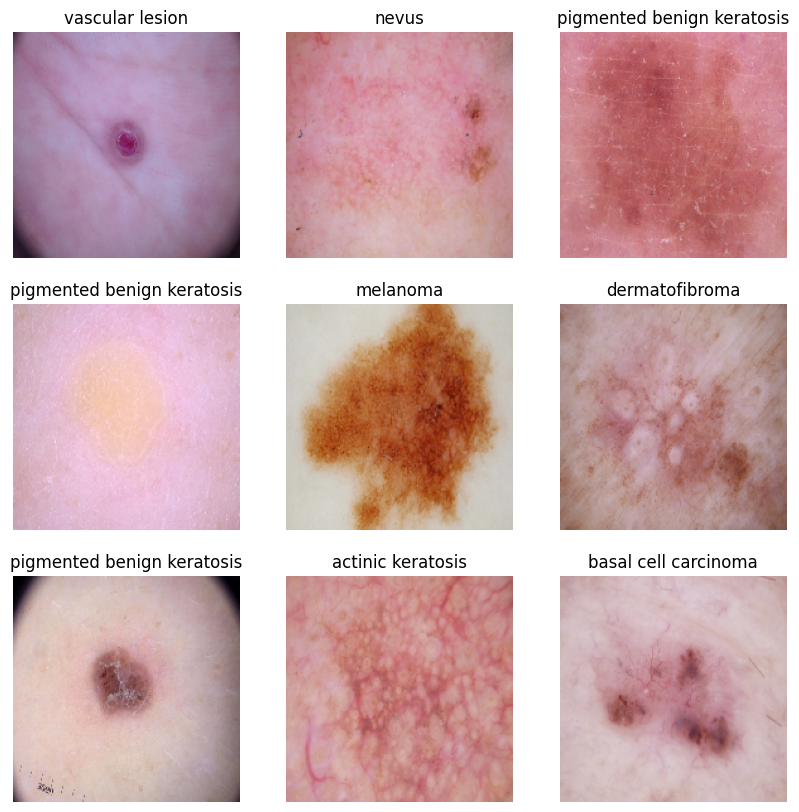

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)) ]


In [17]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model1 = Sequential()
model1.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model1.add(MaxPool2D(pool_size=(2, 2)))

model1.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPool2D(pool_size=(2, 2)))

model1.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPool2D(pool_size=(2, 2)))

model1.add(Flatten())

model1.add(Dense(512, activation='relu'))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1))
model1.add(Activation('sigmoid'))

## Number of classes is 9
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_13 (ModuleWr  (None, 178, 178, 32)     896       
 apper)                                                          
                                                                 
 module_wrapper_14 (ModuleWr  (None, 176, 176, 32)     9248      
 apper)                                                          
                                                                 
 module_wrapper_15 (ModuleWr  (None, 88, 88, 32)       0         
 apper)                                                          
                                                                 
 module_wrapper_16 (ModuleWr  (None, 86, 86, 64)       18496     
 apper)                                               

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [18]:
### Todo, choose an appropirate optimiser and loss function
optimizer = 'adam'
loss_fn = "binary_crossentropy"
model1.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_13 (ModuleWr  (None, 178, 178, 32)     896       
 apper)                                                          
                                                                 
 module_wrapper_14 (ModuleWr  (None, 176, 176, 32)     9248      
 apper)                                                          
                                                                 
 module_wrapper_15 (ModuleWr  (None, 88, 88, 32)       0         
 apper)                                                          
                                                                 
 module_wrapper_16 (ModuleWr  (None, 86, 86, 64)       18496     
 apper)                                               

### Train the model

In [21]:
epochs = 20
batch_size = 32

history = model1.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 647s 3s/step - loss: -123406136.0000 - accuracy: 0.1702 - val_loss: -1227030016.0000 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 4s 65ms/step - loss: -84715380736.0000 - accuracy: 0.1724 - val_loss: -435729039360.0000 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 3s 60ms/step - loss: -3864825954304.0000 - accuracy: 0.1724 - val_loss: -13110396059648.0000 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 3s 61ms/step - loss: -52659507691520.0000 - accuracy: 0.1724 - val_loss: -134218583638016.0000 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 4s 63ms/step - loss: -356357127536640.0000 - accuracy: 0.1724 - val_loss: -756079331901440.0000 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 3s 62ms/step - loss: -1578939499675648.0000 - accuracy: 0.1724 - val_loss: -2943064599429120.0000 - val_accuracy: 0

### Visualizing training results

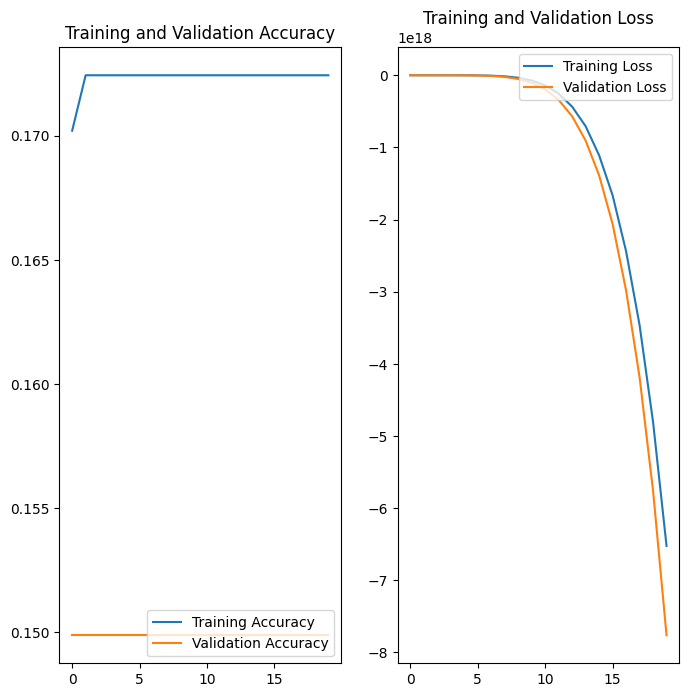

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Observations:
###The model is overfitting because we can also see difference in loss functions in training & test around the 10-11th epoch
###Thus we can see that model Overfit and we need to chose right data augumentation strategy

In [45]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 2390 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


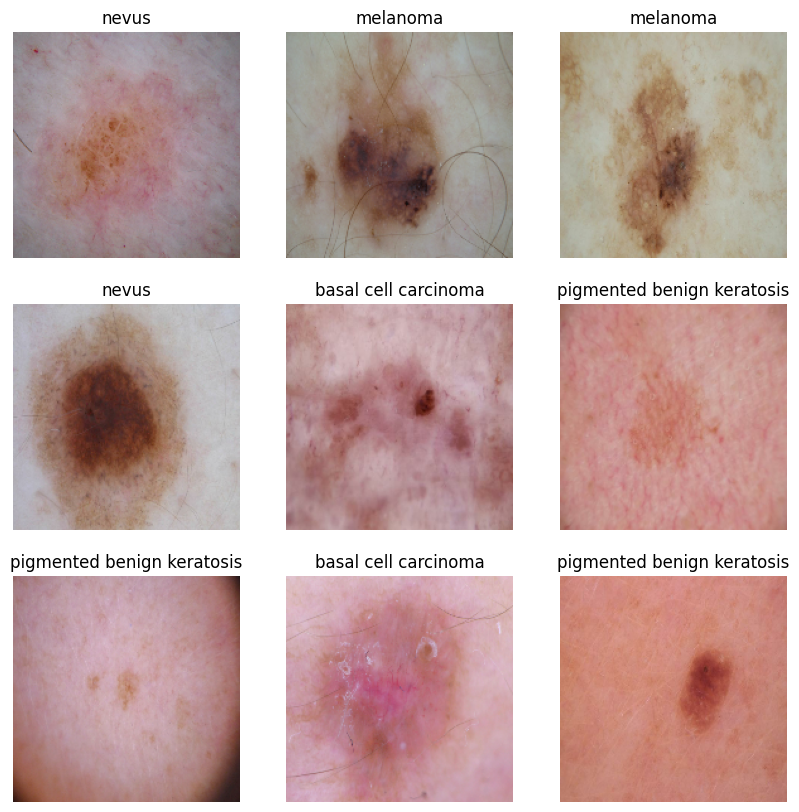

In [46]:
# visualize how your augmentation strategy works for one instance of training image.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [50]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
##Create the model, compile and train the model

model1 = Sequential()

# Increse the model size by adding another 32 layer
model1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model1.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model1.add(Dropout(0.25))

model1.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model1.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Dropout(0.4))

model1.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Dropout(0.4))

model1.add(Flatten())

model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(9, activation='softmax'))



In [ ]:
model1.summary()

In [54]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model1.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

###In order to make the optimizer converge faster and closest to the global minimum of the loss function, Used an annealing method of the learning rate (LR).

###The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

In [55]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)

In [58]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
batch_size = 10
history = model1.fit(train_batches,
  epochs = epochs, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])

Epoch 1/20
38/38 [==============================] - 85s 2s/step - loss: 51.8748 - accuracy: 0.3506 - val_loss: 2.0763 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/20
38/38 [==============================] - 45s 1s/step - loss: 1.0790 - accuracy: 0.4477 - val_loss: 2.0430 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/20
38/38 [==============================] - ETA: 0s - loss: 1.0172 - accuracy: 0.4791
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
38/38 [==============================] - 46s 1s/step - loss: 1.0172 - accuracy: 0.4791 - val_loss: 1.9475 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 5/20
38/38 [==============================] - 47s 1s/step - loss: 0.9088 - accuracy: 0.5565 - val_loss: 1.8704 - val_accuracy: 0.3333 - lr: 5.0000e-04
Epoch 6/20
38/38 [==============================] - 45s 1s/step - loss: 0.9266 - accuracy: 0.5531 - val_loss: 1.8639 - val_accuracy: 0.3333 - lr: 5.0000e-04
Epoch 7/20
38/38 [==============================] - 46s 1s/step - l

<built-in method keys of dict object at 0x7dbba9254200> :


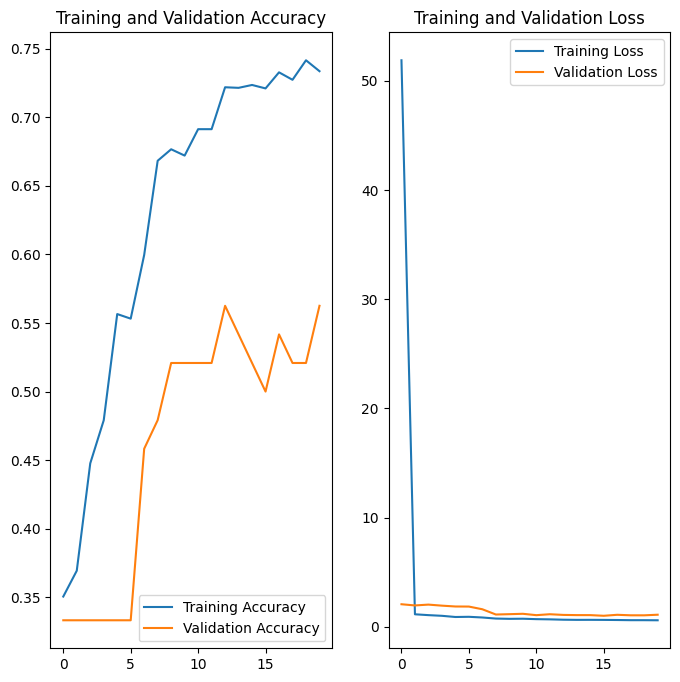

In [59]:
acc = history.history['accuracy']
print(history.history.keys, ":")
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print( model1.evaluate(train_ds, verbose=1))
print(model1.evaluate(val_ds, verbose=1))



Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
Find the distribution of classes in the training dataset.
Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 1000x1000 with 0 Axes>

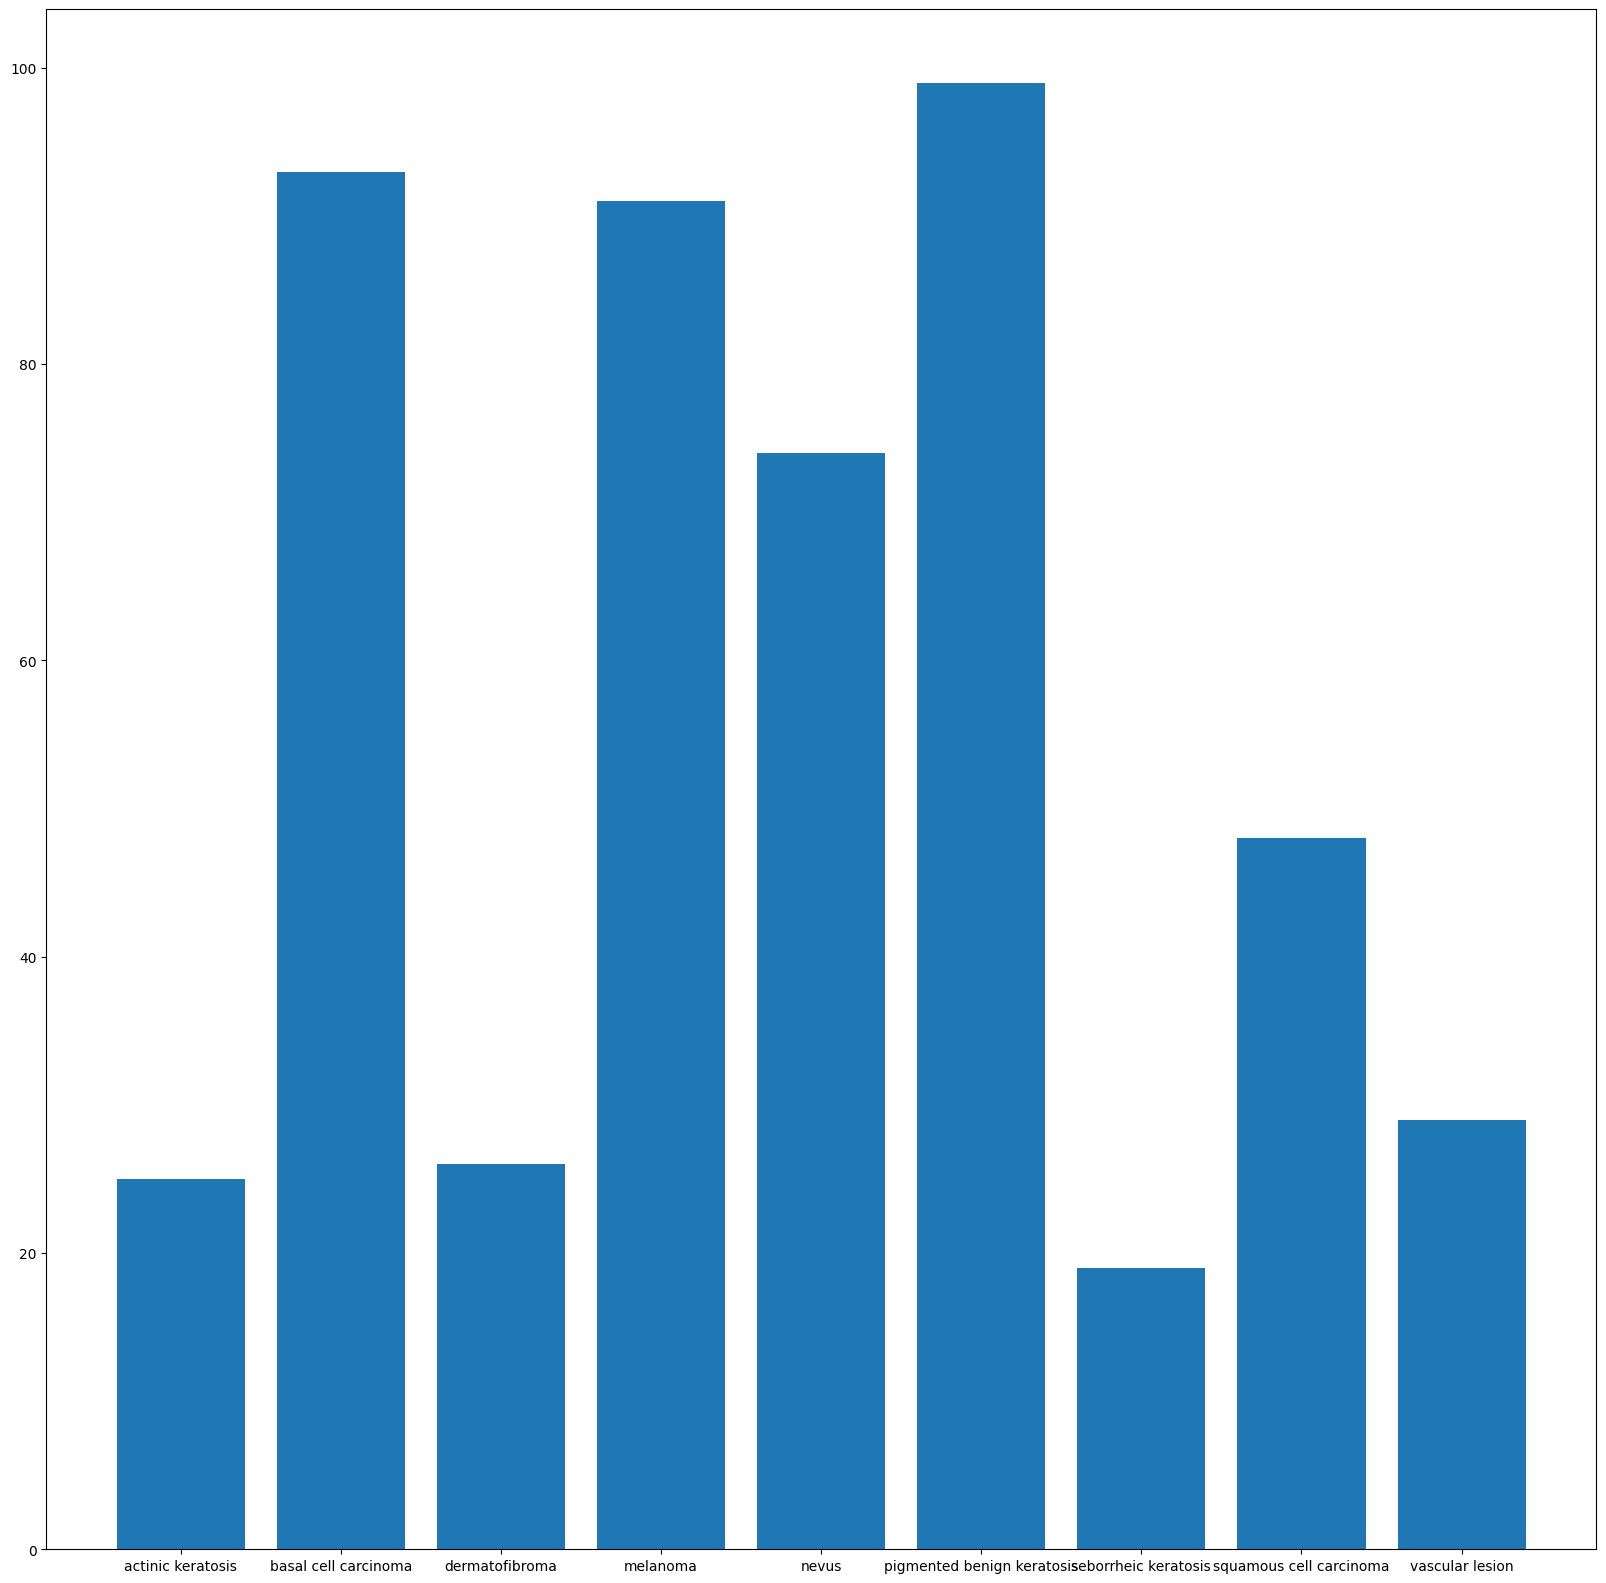

In [23]:
##Need to find distribution of classes in the training dataset.
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i])

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

##Observation :Need to Rectify the class imbalance
###to add more samples across all classes so that none of the classes have very few samples.
###Actinic Keratosos and Seborrheic keratosis are less in count
### Pigmented benign,basal cell carcinoma,melanoma dominate the data proportinate

In [24]:
!pip install Augmentor

# Why do we use Augmentor
##Instantiate a Pipeline object pointing to a directory containing your initial image data set.
##Define a number of operations to perform on this data set using your Pipeline object.
##Execute these operations by calling the Pipeline’s sample() method

In [25]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
path_to_training_dataset="/content/gdrive/MyDrive/CNN/Skin_Data_Store/Skin_cancer_DS /Train/"
# data_dir_train = pathlib.Path(root_path + '/Train')
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
## We are adding 500 samples per class to make sure that none of the classes are sparse.
    p.sample(500)


Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_Data_Store/Skin_cancer_DS /Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DBBAE49A8C0>: 100%|██████████| 500/500 [00:17<00:00, 28.68 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_Data_Store/Skin_cancer_DS /Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DBBAE127820>: 100%|██████████| 500/500 [00:18<00:00, 26.48 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_Data_Store/Skin_cancer_DS /Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DBBAE498940>: 100%|██████████| 500/500 [00:18<00:00, 27.45 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_Data_Store/Skin_cancer_DS /Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DBBAE2941C0>: 100%|██████████| 500/500 [01:28<00:00,  5.63 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_Data_Store/Skin_cancer_DS /Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7DBBAE1E6F50>: 100%|██████████| 500/500 [01:20<00:00,  6.18 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_Data_Store/Skin_cancer_DS /Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DBBAE401060>: 100%|██████████| 500/500 [00:19<00:00, 26.30 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_Data_Store/Skin_cancer_DS /Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DBBAE225B40>: 100%|██████████| 500/500 [00:38<00:00, 12.90 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_Data_Store/Skin_cancer_DS /Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DBBAE1E54E0>: 100%|██████████| 500/500 [00:17<00:00, 28.46 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_Data_Store/Skin_cancer_DS /Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DBBAE401120>: 100%|██████████| 500/500 [00:18<00:00, 27.31 Samples/s]


In [26]:
image_present_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_present_train)

4500


##Observation - 500 images per class (9 classes * 500 = 4500 image count)
###Look at the distribution of augmented data after adding new images to the original training data.

In [27]:
path_list1 = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list1

['/content/gdrive/MyDrive/CNN/Skin_Data_Store/Skin_cancer_DS /Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029460.jpg_4f3aac2e-5591-482c-b14a-9b5188137f6b.jpg',
 '/content/gdrive/MyDrive/CNN/Skin_Data_Store/Skin_cancer_DS /Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030825.jpg_c28359bb-f9c4-4045-a54b-dc43e2f97180.jpg',
 '/content/gdrive/MyDrive/CNN/Skin_Data_Store/Skin_cancer_DS /Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032437.jpg_e17987c9-03b5-4f14-9d57-ccd1c60caa50.jpg',
 '/content/gdrive/MyDrive/CNN/Skin_Data_Store/Skin_cancer_DS /Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026212.jpg_af913e32-e6b9-43e6-99d9-10a13d039837.jpg',
 '/content/gdrive/MyDrive/CNN/Skin_Data_Store/Skin_cancer_DS /Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030143.jpg_9231f40d-e257-43a1-88d4-af9f87872eae.jpg',
 '/content/gdrive/MyDrive/CNN/Skin_Data_Store/Skin_cancer_DS /Train/actinic keratosis/output/actinic

In [28]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [29]:
dataframe_dict_new1 = dict(zip(path_list1, lesion_list_new))

In [30]:
df2 = pd.DataFrame(list(dataframe_dict_new1.items()),columns = ['Path','Label'])
new_df = df2

In [31]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

##Observation - Added 500 images to all the classes to maintain class balance. We can add more images if we want to improve training process.

In [32]:
batch_size = 32
img_height = 180
img_width = 180

In [34]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
##Create a training dataset
data_dir_train="/content/gdrive/MyDrive/CNN/Skin_Data_Store/Skin_cancer_DS /Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [35]:
##Create a validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [38]:
model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))



In [41]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In [42]:
#Train the model
epochs = 50

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)

In [43]:

batch_size = 10
history = model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 47s 251ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - 41s 239ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - 41s 237ms/step - loss: nan - accuracy: 0.1026 - val_loss: nan - val_accuracy: 0.0898 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0914
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
169/169 [==============================] - 41s 236ms/step - loss: nan - accuracy: 0.0914 - val_loss: nan - val_accuracy: 0.0898 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - 45s 261ms/step - loss: nan - accuracy: 0.0914 - val_loss: nan - val_accuracy: 0.0898 - lr: 5.0000e-04
Epoch 6/50
169/169 [==============================] - 41s 236

### Visualizing the results

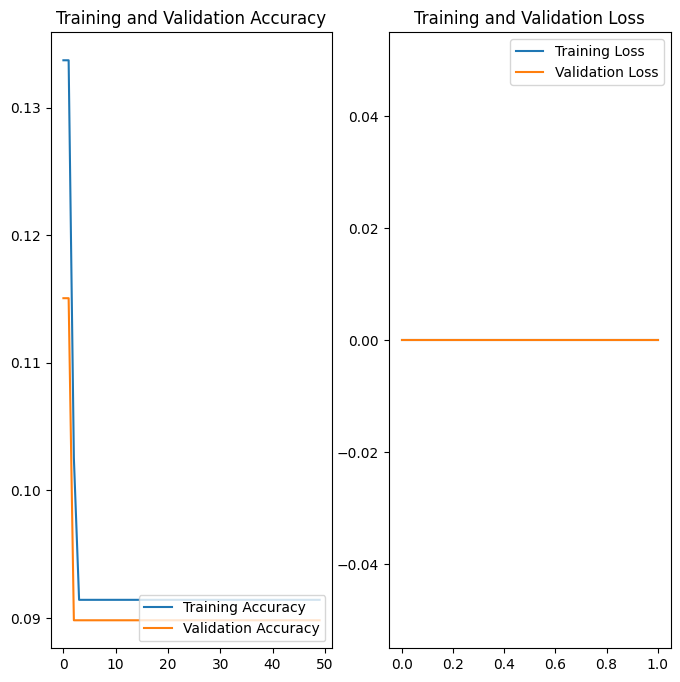

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

####The class rebalance helped in reducing overfititng of the data and thus the loass is beng reduced however it reduced the Acurracy very low

####Initially we tried without the ImageDataGenerator which created data to over fit at high ratio

####Then we introduced dropout and ImageDataGenerator which reduced the over fit

####At last we tried Augumentation which really helped in carry forward

